In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import onnx
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [3]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [4]:
from sklearn.preprocessing import StandardScaler

class ChartDataset(Dataset):

    def __init__(self, X, y, scaler: StandardScaler):
        if scaler is not None:
            X = scaler.transform(X)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape((-1, 1))
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
import json
df = pd.read_csv('nn_dataset.csv')
print(f'loaded {len(df)} items')
# print(f'example = {all_data[0]}')

loaded 4103 items


In [6]:
from sklearn.model_selection import train_test_split

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
limited_data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    #*(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
X_all, y_all = df[limited_data_columns], df['Meter']
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# train_set, test_set = torch.utils.data.random_split(all_data, [.8, .2], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(X_train)}, validation examples = {len(X_test)}")
print(X_train.shape)
print(4101 in X_train.index, 4098 in X_train.index)

train examples = 3282, validation examples = 821
(3282, 17)
True True


In [173]:
print(df.loc[df['Name'] == '_misc/[2017] XS Project Collection Full'].index)
print(df.loc[df['Name'] == '_misc/140BPM Stamina Killer'].index)

Index([4101], dtype='int64')
Index([4098], dtype='int64')


In [597]:
#X_test.loc[4103]
4103 in X_train.index

True

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train.to_numpy())
# print(scaler.mean_, scaler.var_)

,copy,True
,with_mean,True
,with_std,True


In [7]:
import monotonicnetworks as lmn

N_INPUTS = X_all.shape[-1]
class RatingMLP(nn.Module):
    def __init__(self, hidden1_size, hidden2_size):
        super(RatingMLP, self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(N_INPUTS, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, 1)
        )

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingMLPDropout(nn.Module):
    def __init__(self, hidden1_size, hidden2_size, dropout):
        super(RatingMLPDropout, self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(N_INPUTS, hidden1_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2_size, 1)
        )

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingMLPOneHidden(nn.Module):
    def __init__(self, hidden1_size):
        super(RatingMLPOneHidden, self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(N_INPUTS, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, 1)
        )

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingDeepMLP(nn.Module):
    def __init__(self, hidden_sizes):
        super().__init__()

        layers = [
            nn.Linear(N_INPUTS, hidden_sizes[0]),
            nn.ReLU()
        ]
        for i, h in enumerate(hidden_sizes):
            if i == len(hidden_sizes) - 1:
                layers.append(nn.Linear(h, 1))
            else:
                layers.append(nn.Linear(h, hidden_sizes[i+1]))
                layers.append(nn.ReLU())

        self.stack = nn.Sequential(*layers)

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingMonotonicNN(nn.Module):
    def __init__(self, hidden1_size, hidden2_size, n_groups):
        super(RatingMonotonicNN, self).__init__()

        self.lip_nn = nn.Sequential(
            lmn.LipschitzLinear(N_INPUTS, hidden1_size, kind='one-inf'),
            lmn.GroupSort(n_groups),
            lmn.LipschitzLinear(hidden1_size, hidden2_size, kind='inf'),
            lmn.GroupSort(n_groups),
            lmn.LipschitzLinear(hidden2_size, 1, kind='inf')
        )
        self.monotonic_nn = lmn.MonotonicWrapper(self.lip_nn).to(device)

    def forward(self, line_tensor):
        out = self.monotonic_nn(line_tensor)
        return out

class RatingDeepMonotonicNN(nn.Module):
    def __init__(self, hidden_sizes, n_groups):
        super(RatingDeepMonotonicNN, self).__init__()

        layers = [
            lmn.LipschitzLinear(N_INPUTS, hidden_sizes[0], kind='one-inf'),
            lmn.GroupSort(n_groups)
        ]
        for i, h in enumerate(hidden_sizes):
            if i == len(hidden_sizes) - 1:
                layers.append(
                    lmn.LipschitzLinear(h, 1, kind='inf')
                )
            else:
                layers.append(
                    lmn.LipschitzLinear(h, hidden_sizes[i+1], kind='inf')
                )
                layers.append(lmn.GroupSort(n_groups))

        self.lip_nn = nn.Sequential(*layers)
        self.monotonic_nn = lmn.MonotonicWrapper(self.lip_nn).to(device)

    def forward(self, line_tensor):
        out = self.monotonic_nn(line_tensor)
        return out


In [8]:
import random
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy
from torch_lr_finder import LRFinder
from scipy.ndimage import convolve1d
from imbalanced_regression.utils import get_lds_kernel_window
from imbalanced_regression.loss import weighted_mse_loss

class RatingMLPClassifier:
    def __init__(
            self,
            model: nn.Module,
            optim_fn,
            X_train, y_train, X_test, y_test,
            n_epochs,
            batch_size,
            scaler=None,
            scheduler_fn=None,
            criterion=None,
            best_ckp_path='./best.pt',
            use_lds=False
        ):
        self.model = model
        self.optimizer = optim_fn(self.model.parameters())
        
        self.scaler = scaler
        # self.scheduler = ReduceLROnPlateau(
        #     self.optimizer, mode='min',
        #     factor=0.5, patience=20
        # )
        self.scheduler = None
        if scheduler_fn:
            self.scheduler = scheduler_fn(self.optimizer)
        self.criterion = criterion or nn.MSELoss()

        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self._recreate_datasets()

        self.train_losses = []
        self.test_losses = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.total_epochs = 0
        self.best_test_acc = 0
        self.best_ckp_path = best_ckp_path

        self.use_lds = use_lds
        if use_lds:
            vals, counts = np.unique_counts(y_train)
            label_dist = [0 for _ in range(np.max(vals) + 1)]
            for val, count in zip(vals, counts):
                label_dist[val] = count
            lds_kernel = get_lds_kernel_window(
                kernel='gaussian', ks=5, sigma=2
            )
            eff_label_dist = convolve1d(np.asarray(label_dist), weights=lds_kernel, mode='constant')
            weights = (1 / eff_label_dist).astype(np.float32)
            weights[0] = 0 # difficulty 0 doesn't exist
            weights = weights / np.sum(weights) * len(weights)
            self.weights = torch.tensor(weights)
    
    def _recreate_datasets(self):
        """Call this if scaler is changed, so that new dataset objects may be created"""
        rng = torch.Generator(device=device).manual_seed(2024)
        self.dataset = ChartDataset(self.X_train, self.y_train, self.scaler)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, generator=rng)
        self.test_dataset = ChartDataset(self.X_test, self.y_test, self.scaler)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, generator=rng)

    def train(self, new_target=None):
        # note: change this if changing drop_last
        #size = len(dataset)
        size = len(self.dataset) // self.batch_size * self.batch_size
        if self.scaler:
            X_test = self.scaler.transform(X_test)
        X_test = torch.tensor(self.X_test, dtype=torch.float32)
        y_test = torch.tensor(self.y_test, dtype=torch.float32).reshape((-1, 1))
        if new_target is not None:
            self.n_epochs = new_target

        # if self.total_epochs == 0:
        #     # init bias
        #     last_layer: nn.Linear = list(self.model.stack.children())[-1]
        #     mean = np.mean(y_train)
        #     print('init bias to y_train mean: ', mean)
        #     last_layer.bias.data.fill_(mean)

        for epoch_i in range(self.total_epochs, self.n_epochs):
            if self.scheduler:
                print(f"Epoch {epoch_i+1} (last lr={self.scheduler.get_last_lr()[0]:.2e})")
            else:
                print(f"Epoch {epoch_i+1}")
            self.model.train()
            # self.model.zero_grad()
            current_loss, correct = 0, 0

            num_batches = len(self.dataloader)
            for batch_i, (X, y) in enumerate(self.dataloader):
                pred = self.model(X)
                if self.use_lds:
                    #print(y.int())
                    weights = self.weights[y.int()]
                    #print(weights)
                    loss = weighted_mse_loss(pred, y, weights)
                else:
                    loss = self.criterion(pred, y)

                current_loss += loss.item()
                correct += (torch.round(pred) == y).type(torch.float).sum().item()
                
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 20)
                self.optimizer.step()
                # if using 1cycle, uncomment the below line
                if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    self.scheduler.step()
                self.optimizer.zero_grad()
            
            current_loss /= num_batches
            correct /= size
            self.train_losses.append(current_loss)
            self.train_accuracy.append(correct)
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {current_loss:>8f}")
            # if self.scheduler:
            #     self.scheduler.step(current_loss)
            self.total_epochs += 1
            
            self.test(X_test, y_test)
            # self.test_with_dataloader(test_dataloader)
    
    def test_with_dataloader(self, dataloader):
        test_loss, correct = 0, 0
        size = 0
        num_batches = len(dataloader)
        self.model.eval()
        with torch.no_grad():
            for X, y in dataloader:
                size += len(X)
                pred = self.model(X)
                test_loss += self.criterion(pred, y).item()
                correct += (torch.round(pred) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        self.test_losses.append(test_loss)
        self.test_accuracy.append(correct)
        print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        # save best model
        if correct > self.best_test_acc:
            print(f'Saving best model at {self.best_ckp_path}')
            self.best_test_acc = correct
            self.save_ckp(self.best_ckp_path)
        else:
            print(f'Does not beat best model ({(100*self.best_test_acc):>0.1f}%)')
    
    def test(self, X_test: torch.Tensor, y_test: torch.Tensor):
        test_loss, correct = 0, 0
        self.model.eval()
        with torch.no_grad():
            preds = self.model(X_test)
            test_loss = self.criterion(preds, y_test).item()
            correct = (torch.round(preds) == y_test).type(torch.float).mean().item()
        self.test_losses.append(test_loss)
        self.test_accuracy.append(correct)
        print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        # save best model
        if correct > self.best_test_acc:
            print(f'Saving best model at {self.best_ckp_path}')
            self.best_test_acc = correct
            self.save_ckp(self.best_ckp_path)
        else:
            print(f'Does not beat best model ({(100*self.best_test_acc):>0.1f}%)')

    def predict(self, X_test):
        if self.scaler:
            X_test = self.scaler.transform(X_test)
        self.model.eval() #set to eval mode
        with torch.no_grad(): # do not record the gradients during eval phase
            y = self.model(torch.tensor(X_test, dtype=torch.float32))
        return y
    
    def save_ckp(self, path):
        ckp = {
            'model': self.model.state_dict(),
            'n_epochs': self.total_epochs,
            'best_test_acc': self.best_test_acc,
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict() if self.scheduler else None,
            'train_losses': self.train_losses,
            'test_losses': self.test_losses,
            'train_accuracy': self.train_accuracy,
            'test_accuracy': self.test_accuracy,
            'scaler': self.scaler
        }
        torch.save(ckp, path)
    
    def load_ckp(self, path):
        with torch.serialization.safe_globals([
            #numpy._core.multiarray._reconstruct,
            numpy.dtype,
            numpy.dtypes.Int64DType,
            numpy.dtypes.Float64DType,
            #numpy._core.multiarray.scalar,
            numpy.ndarray,
            StandardScaler,
        ]):
            ckp = torch.load(path)
        self.model.load_state_dict(ckp['model'])
        self.optimizer.load_state_dict(ckp['optimizer'])
        # self.scheduler = ReduceLROnPlateau(
        #     self.optimizer, mode='min',
        #     factor=0.5, patience=20
        # )
        if 'scheduler' in ckp and ckp['scheduler']:
            self.scheduler.load_state_dict(ckp['scheduler'])
        self.best_test_acc = ckp['best_test_acc']
        self.total_epochs = ckp['n_epochs']
        self.train_losses = ckp['train_losses']
        self.test_losses = ckp['test_losses']
        self.train_accuracy = ckp['train_accuracy']
        self.test_accuracy = ckp['test_accuracy']
        self.scaler = ckp['scaler']
        self._recreate_datasets()

    def lr_find(self, **kwargs):
        lr_finder = LRFinder(self.model, self.optimizer, self.criterion, device="cuda")
        lr_finder.range_test(self.dataloader, **kwargs)
        lr_finder.plot() # to inspect the loss-learning rate graph
        lr_finder.reset() # to reset the model and optimizer to their initial state
        return lr_finder

c:\Users\Lenovo\Documents\code_projs\itg-difficulty-predictor\.venv\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [897]:
from scipy.ndimage import convolve1d
from imbalanced_regression.utils import get_lds_kernel_window

vals, counts = np.unique_counts(y_train)
label_dist = [0 for _ in range(0, np.max(vals) + 1)]
for val, count in zip(vals, counts):
    label_dist[val] = count
lds_kernel_window = get_lds_kernel_window(
    kernel='gaussian', ks=5, sigma=2
)
print(counts)
print(label_dist)
eff_label_dist = convolve1d(np.asarray(counts), weights=lds_kernel_window, mode='constant')
weights = (1 / eff_label_dist).astype(np.float32)
weights[0] = 0 # difficulty 0 doesn't exist
weights = weights / np.sum(weights) * len(weights)
print(eff_label_dist)
print(eff_label_dist.shape, counts.shape)
print(weights)

[128  30  83  68  86  67 101 138 174 159 190 227 166 135 121 103  94 102
  84  82  74  73  70  67  71  72  62  58  42  46  34  38  45  40  56  42
  18  13   6   7   5   5   2]
[0, np.int64(128), np.int64(30), np.int64(83), np.int64(68), np.int64(86), np.int64(67), np.int64(101), np.int64(138), np.int64(174), np.int64(159), np.int64(190), np.int64(227), np.int64(166), np.int64(135), np.int64(121), np.int64(103), np.int64(94), np.int64(102), np.int64(84), np.int64(82), np.int64(74), np.int64(73), np.int64(70), np.int64(67), np.int64(71), np.int64(72), np.int64(62), np.int64(58), np.int64(42), np.int64(46), np.int64(34), np.int64(38), np.int64(45), np.int64(40), np.int64(56), np.int64(42), np.int64(18), np.int64(13), np.int64(6), np.int64(7), np.int64(5), np.int64(5), np.int64(2)]
[227 287 359 311 371 420 518 592 704 816 846 816 775 689 569 509 463 429
 402 381 352 337 326 324 315 305 281 257 222 200 188 186 196 204 187 157
 123  77  44  32  23  17  11]
(43,) (43,)
[ 0.          0.3991169

In [9]:
model_name = 'model6'
classifier = RatingMLPClassifier(
    RatingDeepMonotonicNN([512, 512], 8),
    #RatingMLP(512, 512),
    lambda p: torch.optim.Adam(p, lr=1e-1),
    X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(),
    3000, 64,
    scaler=None,
    # scheduler_fn=lambda optim: torch.optim.lr_scheduler.OneCycleLR(
    #     optim, max_lr=2.5, steps_per_epoch=len(X_train)//64, epochs=1000
    # ),
    criterion=nn.MSELoss(),
    #best_ckp_path='checkpoints/monotest2/model6_best.pt',
    use_lds=False
)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-01


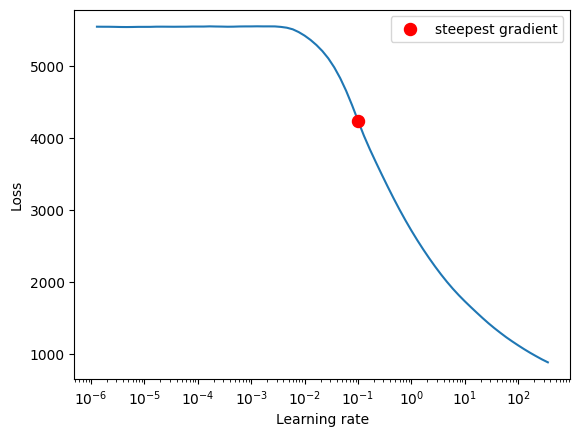

In [214]:
lr_finder = classifier.lr_find(
    val_loader=classifier.test_dataloader,
    start_lr=1e-7, end_lr=10000, num_iter=100
)

In [89]:
torch.serialization.get_unsafe_globals_in_checkpoint(classifier.best_ckp_path)

['numpy._core.multiarray._reconstruct',
 'sklearn.preprocessing._data.StandardScaler',
 'numpy.dtype',
 'numpy._core.multiarray.scalar',
 'numpy.ndarray']

In [10]:
classifier.load_ckp('checkpoints/monotest2/model5_best.pt')
print(classifier.best_test_acc, min(classifier.test_losses), classifier.total_epochs)

0.7515225410461426 0.2341555505990982 2604


In [221]:
classifier.train(3000)

Epoch 1
Train Error: Accuracy: 15.6%, Avg loss: 433.746184
Test Error: Accuracy: 31.9%, Avg loss: 1.693315
Saving best model at checkpoints/monotest2/model6_best.pt
Epoch 2
Train Error: Accuracy: 30.2%, Avg loss: 1.676259
Test Error: Accuracy: 29.8%, Avg loss: 1.706764
Does not beat best model (31.9%)
Epoch 3
Train Error: Accuracy: 31.1%, Avg loss: 1.590493
Test Error: Accuracy: 32.0%, Avg loss: 1.527711
Saving best model at checkpoints/monotest2/model6_best.pt
Epoch 4
Train Error: Accuracy: 33.1%, Avg loss: 1.522036
Test Error: Accuracy: 33.1%, Avg loss: 1.484719
Saving best model at checkpoints/monotest2/model6_best.pt
Epoch 5
Train Error: Accuracy: 32.0%, Avg loss: 1.597978
Test Error: Accuracy: 33.7%, Avg loss: 1.446256
Saving best model at checkpoints/monotest2/model6_best.pt
Epoch 6
Train Error: Accuracy: 35.2%, Avg loss: 1.397750
Test Error: Accuracy: 36.7%, Avg loss: 1.282380
Saving best model at checkpoints/monotest2/model6_best.pt
Epoch 7
Train Error: Accuracy: 36.6%, Avg los

In [222]:
#torch.save(classifier.model.state_dict(), 'checkpoints/npslentest/model4.pt')
classifier.save_ckp('checkpoints/monotest2/model6_3000.pt')

In [11]:
classifier.best_test_acc

0.7515225410461426

In [9]:
example_inputs, _ = classifier.test_dataset[0]
onnx_program = torch.onnx.export(classifier.model, example_inputs, dynamo=True)

: 

## Plots

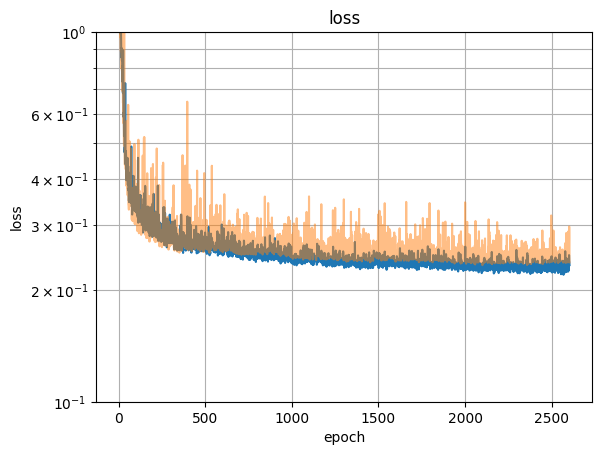

In [12]:
# plot loss ==================
t = np.arange(0.0, len(classifier.train_losses), 1)
s = classifier.train_losses

fig, ax = plt.subplots()
ax.plot(t, s)

t = np.arange(0.0, len(classifier.test_losses), 1)
s = [x for x in classifier.test_losses]
ax.plot(t, s, alpha=0.5)

ax.set(xlabel='epoch', ylabel='loss',
       title='loss')
ax.set_ylim([0.1, 1])
ax.set_yscale('log')
ax.grid(which='both')
#fig.text(0.5, -0.1, '''Train Error: Accuracy: 22.2%, Avg loss: 3.625307''', wrap=True, horizontalalignment='center', fontsize=12)

#fig.savefig("test.png")
plt.show()

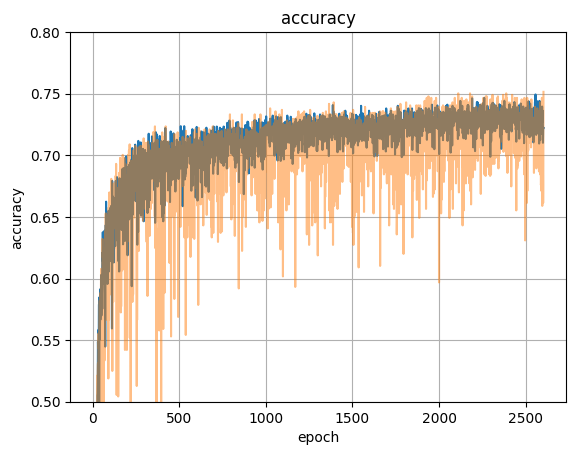

In [13]:
# plot accuracy ==================
fig, ax = plt.subplots()
t = np.arange(0.0, len(classifier.train_accuracy), 1)
s = classifier.train_accuracy
ax.plot(t, s)
t = np.arange(0.0, len(classifier.test_accuracy), 1)
s = classifier.test_accuracy
ax.plot(t, s, alpha=0.5)

ax.set(xlabel='epoch', ylabel='accuracy',
       title='accuracy')
ax.grid(which='both')
ax.set_ylim([0.5, 0.8])
plt.show()

correct: 0.7515225334957369 / 821
mae: 0.37239540741301336 / 821


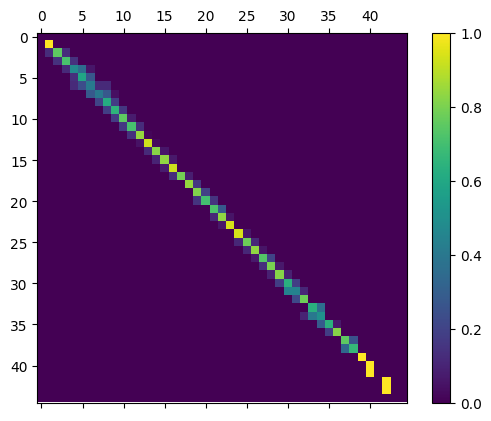

In [14]:
def display_confusion(X, y):
    width = 43-1+3
    confusion = torch.zeros(width, width)

    preds = classifier.predict(X.to_numpy())
    ys = y

    correct_count = 0
    cum_err = 0
    for pred, true_meter in zip(preds, ys):
        pred = pred.item()
        guess_meter = round(pred)
        guess_meter = max(0, min(44, guess_meter))

        cum_err += abs(pred - true_meter)
        
        if true_meter == guess_meter:
            correct_count += 1
        true_meter = max(0, min(44, true_meter))
        confusion[int(true_meter)][int(guess_meter)] += 1
    
    correct_count = (preds.cpu().numpy().squeeze().round() == y).sum()
    print(f"correct: {correct_count / len(ys)} / {len(ys)}")
    print(f"mae: {cum_err / len(ys)} / {len(ys)}")

    # Normalize by dividing every row by its sum
    for i in range(width):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    # ax.set_xticks(np.arange(width))
    # ax.set_yticks(np.arange(width))
    #ax.tick_params(axis='both', labelsize=5)
    #ax.tick_params(axis='x', labelrotation=90)

    # Force label at every tick
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

display_confusion(X_test, y_test)

In [11]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh import palettes

output_notebook()

Loading BokehJS ...

In [12]:
from bokeh.models.tickers import BasicTicker
def bokeh_display(X, y, names_df=None, palette=palettes.Turbo256):
    if names_df is None:
        names_df = df
    preds = classifier.predict(X.to_numpy()).cpu().numpy()
    correct_count = 0
    cum_err = 0
    for pred, true_meter in zip(preds, y):
        guess_meter = round(pred[0])
        cum_err += abs(pred - true_meter)        
        if true_meter == guess_meter:
            correct_count += 1
    print(f"correct: {correct_count / len(y) * 100:.3f}% of {len(y)} charts")
    print(f"mae: {cum_err / len(y)}")

    disp_df = pd.DataFrame(index=y.index)
    disp_df['y'] = preds
    disp_df['x'] = y
    disp_df.set_index
    disp_df = disp_df.merge(names_df[['Name', 'Meter']], left_index=True, right_index=True)

    datasource = ColumnDataSource(disp_df)
    color_mapping = LinearColorMapper(
        palette=palette
    )

    plot_figure = figure(
        width=500,
        height=500,
        tools=('pan, wheel_zoom, reset')
    )

    hvr = HoverTool(tooltips="""
    <div>
        <div>
            <span style='font-size: 12px; color: #224499'>[@Meter]</span>
            <span style='font-size: 12px; color: #994422'>[@y]</span>
            <span style='font-size: 12px'>@Name</span>
        </div>
    </div>
    """)
    plot_figure.add_tools(hvr)

    scatter = plot_figure.scatter(
        'x',
        'y',
        source=datasource,
        color=dict(field='Meter', transform=color_mapping),
        line_alpha=0,
        fill_alpha=0.2,
        size=8
    )
    hvr.renderers = [scatter]
    line_vals = np.arange(min(y), max(y)+1)
    plot_figure.line(x=line_vals, y=line_vals)
    plot_figure.ygrid.ticker = BasicTicker(min_interval=1, max_interval=1)
    show(plot_figure)

bokeh_display(X_test, y_test, palette=palettes.Turbo256*2)

correct: 75.152% of 821 charts
mae: [0.37239504]


In [13]:
import math
from fractions import Fraction

def get_block_repr(bpm, measures):
    THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
    BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]

    nps = bpm * 4 / 60
    measure_len = 60 / bpm * 4
    max_nps = nps #math.ceil(nps)
    max_nps_lower = max_nps - 1
    length_secs = measure_len * measures
    length = length_secs * 2

    prop_higher = nps % 1 if nps < max_nps else 1
    prop_lower = 1 - prop_higher
    lower_bin_i = -1
    for thresh in THRESHOLDS:
        if max_nps_lower > thresh * max_nps:
            lower_bin_i += 1
        else:
            break
    
    avg_nps_per_bin = [(t+0.1) * max_nps for t in THRESHOLDS]
    nps_vals_are_in_same_bin = lower_bin_i == len(THRESHOLDS) - 1 or nps == max_nps
    if nps_vals_are_in_same_bin:
        avg_nps_per_bin[-1] = nps
    else:
        avg_nps_per_bin[-1] = max_nps
        if lower_bin_i > -1:
            avg_nps_per_bin[lower_bin_i] = max_nps_lower
    
    threshold_counts = [length for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = length * prop_higher
    
    density_per_bin = [1 for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = prop_higher    

    # longest continuous block of NPS >= threshold
    # allowing for different lengths of break
    longest_blocks = [[length for _ in BREAK_LENGTHS] for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        #print(nps, lower_bin_i, prop_higher, prop_lower)
        ratio_higher_to_lower = prop_higher / prop_lower
        if ratio_higher_to_lower > 1:
            block_len = math.ceil(ratio_higher_to_lower)
            break_len = 1
        else:
            block_len = 1
            break_len = math.ceil(1 / ratio_higher_to_lower)
        for thresh_i in range(lower_bin_i+1, len(THRESHOLDS)):
            for break_i, max_break_len in enumerate(BREAK_LENGTHS):
                if break_len > max_break_len:
                    longest_blocks[thresh_i][break_i] = block_len

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin,
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin,
        #*(math.log2(x+1) for row in longest_blocks for x in row)
    ]

In [14]:
get_block_repr(40, 160)

[2.6666666666666665,
 10.907641803665527,
 0.26666666666666666,
 0.8,
 1.3333333333333333,
 1.8666666666666665,
 2.6666666666666665,
 10.907641803665527,
 10.907641803665527,
 10.907641803665527,
 10.907641803665527,
 10.907641803665527,
 1,
 1,
 1,
 1,
 1]

In [15]:
inp = get_block_repr(40, 160)
#print(inp)
classifier.predict([inp])

tensor([[6.1857]], device='cuda:0')

In [195]:
inp = [get_block_repr(bpm, 32) for bpm in range(10, 520, 10)]
#print(inp)
out = classifier.predict(inp)
for i, r in enumerate(out):
    print(10+i*10, r+0.5)

10 tensor([3.7134], device='cuda:0')
20 tensor([4.0626], device='cuda:0')
30 tensor([4.7278], device='cuda:0')
40 tensor([5.5716], device='cuda:0')
50 tensor([6.6658], device='cuda:0')
60 tensor([7.5018], device='cuda:0')
70 tensor([8.3920], device='cuda:0')
80 tensor([9.3774], device='cuda:0')
90 tensor([9.9651], device='cuda:0')
100 tensor([10.5730], device='cuda:0')
110 tensor([11.2217], device='cuda:0')
120 tensor([11.8689], device='cuda:0')
130 tensor([12.2856], device='cuda:0')
140 tensor([12.5931], device='cuda:0')
150 tensor([13.1181], device='cuda:0')
160 tensor([13.6984], device='cuda:0')
170 tensor([14.3055], device='cuda:0')
180 tensor([14.9814], device='cuda:0')
190 tensor([15.7096], device='cuda:0')
200 tensor([16.4583], device='cuda:0')
210 tensor([17.3185], device='cuda:0')
220 tensor([18.3290], device='cuda:0')
230 tensor([19.4711], device='cuda:0')
240 tensor([20.6443], device='cuda:0')
250 tensor([21.7896], device='cuda:0')
260 tensor([22.9002], device='cuda:0')
270 

In [356]:
RESOLUTION = 200
STREAM_BOUNDS = (0, 16)
BPM_BOUNDS = (10, 600)
x, y = np.meshgrid(
    np.linspace(BPM_BOUNDS[0], BPM_BOUNDS[1], RESOLUTION),
    np.linspace(STREAM_BOUNDS[0], STREAM_BOUNDS[1], RESOLUTION)
)
inp = np.reshape(np.dstack((x, y)), (-1, 2))
inp = [get_block_repr(item[0], 2**item[1]) for item in inp]
image = classifier.predict(inp)
image = image.cpu().numpy().reshape((RESOLUTION, RESOLUTION))
# out = classifier.model(torch.tensor(inp, dtype=torch.float32))
# out = out.detach().numpy().reshape((RESOLUTION, RESOLUTION)).round()

0.66607285 66.3354


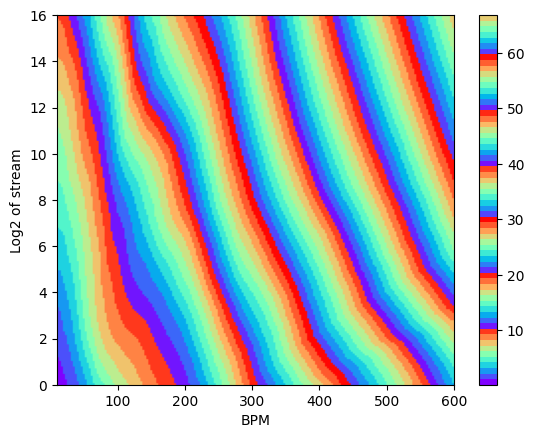

In [357]:
import matplotlib
from matplotlib.colors import ListedColormap, Normalize

vmin = np.min(image)
vmax = np.max(image)
print(vmin, vmax)
norm = Normalize(vmin=vmin-0.5, vmax=vmax+0.5)
#norm = Normalize(vmin=0, vmax=70)
cmap = matplotlib.colormaps['rainbow']
#cmap = ListedColormap(cmap(np.linspace(0, 7, int(500)) % 1))
cmap = ListedColormap(cmap(np.linspace(0, round(vmax-vmin+1)/10, int(vmax-vmin+1)) % 1))
# cmap = matplotlib.colormaps['viridis']

fig = plt.figure()
ax = fig.add_subplot()

#ax.view_init(elev=90, azim=-90, roll=0)
ax.set_xlabel('BPM')
ax.set_ylabel('Log2 of stream')
#ax.set_zlabel('Density')
pos = ax.imshow(image, origin='lower', cmap=cmap, alpha=1, extent=(*BPM_BOUNDS, *STREAM_BOUNDS),
          aspect='auto', norm=norm)
fig.colorbar(pos)
plt.show()

In [17]:
from analysis.analyzer import SongAnalyzer
from analysis.hash import get_hash
import math
import itertools
import simfile
from analysis.features import get_seq, extract_features, THRESHOLDS, BREAK_LENGTHS

data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
columns = [
    'Name', 'Hash', 'Meter',
    *data_columns
]

def handle_song(song, pack_name, seen_hashes):
    data = []
    song_analyzer = SongAnalyzer(song)
    song_str = f'{pack_name}/{song.title or ""}'

    for chart_analyzer in song_analyzer.chart_analyzers.values():
        chart = chart_analyzer.chart
        if (chart.stepstype or '').lower() != 'dance-single':
            continue
        diff = (chart.difficulty or '').lower()
        title = song_str
        if diff != 'challenge':
            title += f' ({diff})'

        chart_hash = get_hash(song, chart_analyzer.chart)
        if chart_hash in seen_hashes:
            print(f'skipping {title} (dupe hash)')
            continue
        seen_hashes.add(chart_hash)
        print(f'analyzing {title}')
        try:
            meter = int(chart_analyzer.chart.meter)
        except ValueError:
            print(song.title, ': invalid meter')
            continue

        note_times = chart_analyzer.get_note_times()
        seq = list(get_seq(note_times))
        if not seq:
            print(title, ': empty?')
            continue
        # print(seq)
        features = extract_features(seq)
        #print(features)

        data.append((
            title,
            chart_hash,
            meter,
            *features
        ))
    return data

In [18]:
from simfile.dir import SimfilePack
import simfile
import glob

#glob_path = r"C:\Users\Lenovo\AppData\Roaming\ITGmania\Songs\that's *"
glob_path = r'pack_archive\BLACKLIGHT'
real_test_data = []
seen_hashes = set()
# for path in glob.glob(glob_path):
#      pack = SimfilePack(path)
#      for song in pack.simfiles(strict=False):
#           real_test_data.extend(handle_song(song, pack.name, seen_hashes))

song = simfile.open(r'C:\Users\Lenovo\AppData\Roaming\ITGmania\Songs\BemaniBeats 6\Deadly force\deadly.sm')
real_test_data.extend(handle_song(song, '_misc', seen_hashes))

test_df = pd.DataFrame(real_test_data, columns=columns)
X_real, y_real = test_df[limited_data_columns], test_df['Meter']

analyzing _misc/Deadly force
analyzing _misc/Deadly force (hard)
analyzing _misc/Deadly force (medium)
analyzing _misc/Deadly force (edit)
analyzing _misc/Deadly force (easy)
analyzing _misc/Deadly force (beginner)


In [97]:
long_stuff_df = test_df
long_stuff_df

,Name,Hash,Meter,Max NPS,Log Length,N_0,N_0.2,N_0.4,N_0.6,N_0.8,T_0,T_0.2,T_0.4,T_0.6,T_0.8,PS_0,PS_0.2,PS_0.4,PS_0.6,PS_0.8
0,_misc/24 hours of 100 bpm stream (beginner),b9db1c5d8023eb40907a71fe5a944cf99ba3a879,1,1,17.398710,0.1,0.3,0.5,0.7,1.000000,16.135729,16.135729,16.135729,16.135729,16.135729,0.416679,0.416679,0.416679,0.416679,0.416679
1,_misc/24 hours of 100 bpm stream (easy),d7ea212a84659dbe7d1329677b559e7eab150166,1,1,17.398727,0.1,0.3,0.5,0.7,1.000000,17.135719,17.135719,17.135719,17.135719,17.135719,0.833348,0.833348,0.833348,0.833348,0.833348
2,_misc/24 hours of 100 bpm stream (medium),d0b9104caaaef463dfe04ca77513fe02e9601d2f,1,2,17.398752,0.2,0.6,1.0,1.4,2.000000,17.398752,17.398752,17.398752,16.813794,16.813794,1.000000,1.000000,1.000000,0.666674,0.666674
3,_misc/24 hours of 100 bpm stream (hard),465f2216a8c13cc4ce18e8dac103d79c4d1d5dad,1,4,17.398760,0.4,1.0,2.0,3.0,4.000000,17.398760,17.398760,17.398752,17.398744,15.813806,1.000000,1.000000,1.000000,1.000000,0.333337
4,_misc/24 hours of 100 bpm stream,961629f4a1fc35c863ed378d82a29d3a8e5c1d2c,1,7,17.398760,0.7,2.1,3.5,4.9,6.666665,17.398760,17.398760,17.398760,17.398744,17.398744,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
bokeh_display(X_real, y_real, test_df)

correct: 66.667% of 6 charts
mae: [0.5391674]


1.0
100.00000000000001
20.412414523193153
10.197055230420512
[ 8.88241063 10.11354952 10.08615153 10.11428431 10.08960995 10.11080856
 10.09311385 10.10729186 10.09663891 10.10374844 10.09093178  8.44570411
  0.09622438]
[ 5.98256281 10.0217919  10.02092529 10.02028537 10.01936793 10.01926601]


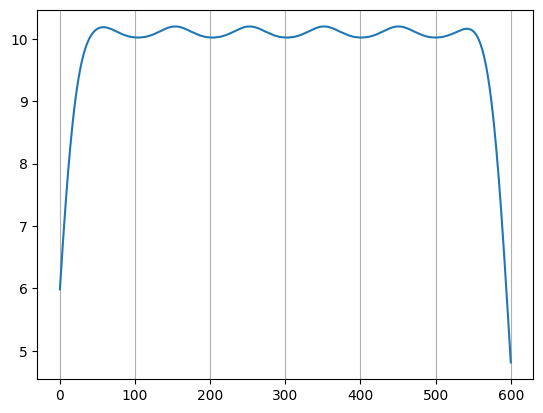

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
# 100 samples = 1 sec
test_nps = 10.1
spacing = 100 / test_nps
length_secs = 6
window_len = 100
points_spacing = 50
idxs = (np.arange(0, length_secs * test_nps) * spacing).round().astype(int)
a = np.zeros(round(length_secs * 100) + 1)
a[idxs] = 1
r = np.arange(window_len)
box = np.ones((50,))
box = box / np.sum(box)
v = (window_len + 1 - np.abs(r - r[::-1]))
v = v / np.sum(v) * 100

print(box.sum())
print(v.sum())

#conv = np.convolve(a, v)
var = (50**2/12) * 2
conv = gaussian_filter1d(a, np.sqrt(var), mode='constant') * 100
print(np.sqrt(var))
# conv = np.convolve(a, box) * 100
# conv = np.convolve(conv, box)
# conv = np.convolve(conv, box)
plt.plot(conv)
plt.grid(axis='x')
print(np.max(conv))
n_points = len(conv) // points_spacing + 1
print(np.pad(
    conv, [0, n_points*points_spacing - len(conv)], constant_values=0
).reshape(n_points, points_spacing) @ np.ones(points_spacing) / points_spacing)
print(conv[np.arange(0, 600, 100, dtype=np.int32)])
# [7.84313725e-04 3.12470588e+00 3.26666667e+00 3.33411765e+00 3.29882353e+00 3.25490196e+00]

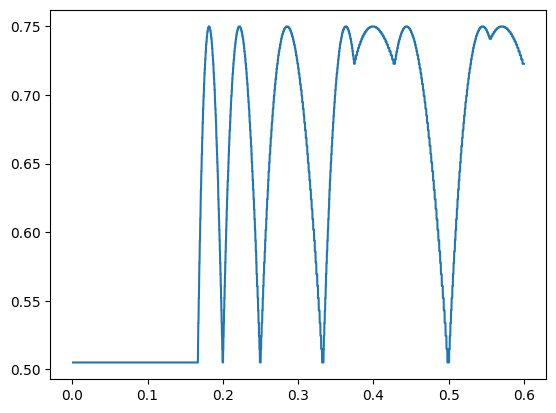

In [879]:
def calc_max_sample(test_nps):
    spacing = 100 / test_nps
    length_secs = 6
    window_len = 199
    points_spacing = 100
    idxs = (np.arange(0, length_secs * test_nps) * spacing).round().astype(int)
    a = np.zeros(round(length_secs * 100) + 1)
    a[idxs] = 1
    r = np.arange(window_len)
    #v = np.ones((100,))
    v = (window_len + 1 - np.abs(r - r[::-1]))
    v = v / np.sum(v) * 100

    conv = np.convolve(a, v)
    n_points = len(conv) // points_spacing + 1
    samples = np.pad(
        conv, [0, n_points*points_spacing - len(conv)], constant_values=0
    ).reshape(n_points, points_spacing) @ np.ones(points_spacing) / points_spacing
    return np.max(samples)

xs = np.arange(0.001, 0.6, 0.0002)
plt.plot(xs, [calc_max_sample(x) for x in xs])

## Captum

In [234]:
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

In [332]:
ig = IntegratedGradients(classifier.model)

In [344]:
baseline = torch.tensor(
    [np.mean(X_test, axis=0)],
    dtype=torch.float32
)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_input.requires_grad_()
attr, delta = ig.attribute(test_input, baselines=baseline, return_convergence_delta=True)
attr = attr.detach().cpu().numpy()

Average Feature Importances


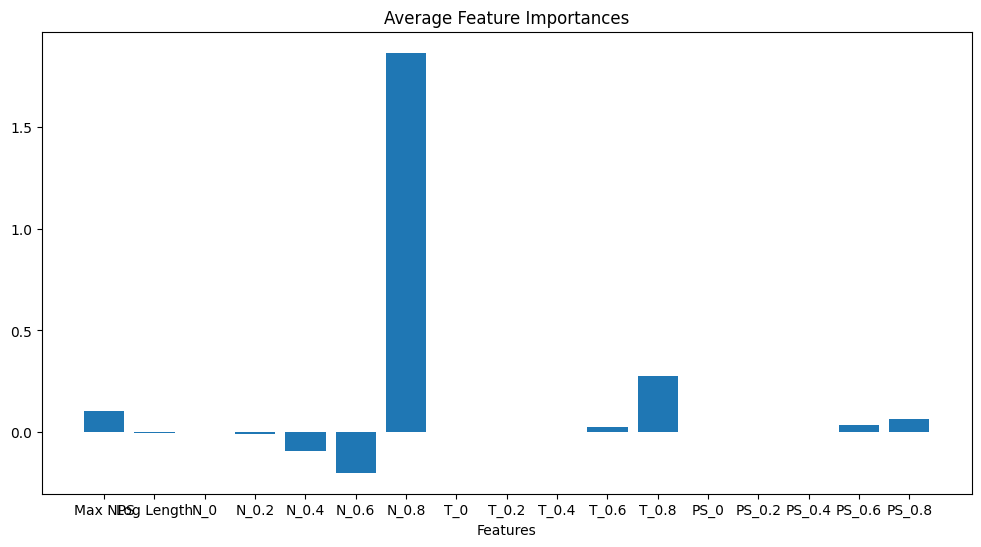

In [346]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    # for i in range(len(feature_names)):
    #     print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(limited_data_columns, np.mean(attr, axis=0))

Text(0.5, 1.0, 'distribution of attr values')

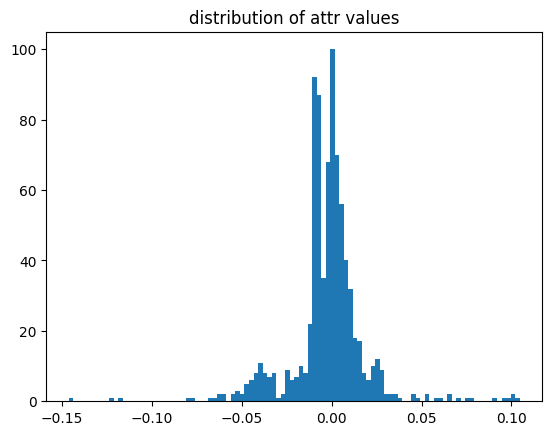

In [348]:
plt.hist(attr[:,limited_data_columns.index('Log Length')], 100)
plt.title('distribution of attr values')

Text(0, 0.5, 'Average Attribution')

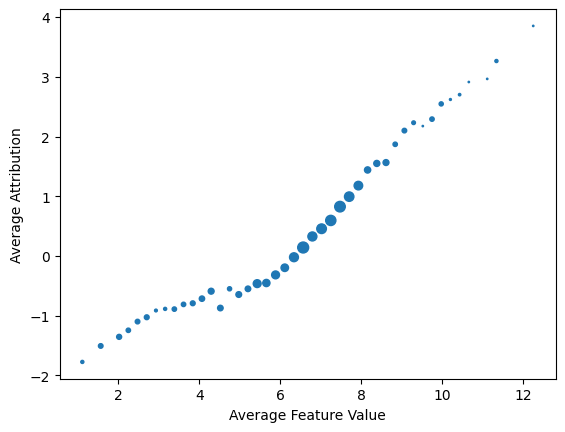

In [354]:
from scipy import stats
test_features = X_test.to_numpy()
feat_i = limited_data_columns.index('T_0.8')
bins = 50
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,feat_i], attr[:,feat_i], statistic='mean', bins=bins)
bin_count, _, _ = stats.binned_statistic(test_features[:,feat_i], attr[:,feat_i], statistic='count', bins=bins)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Feature Value")
plt.ylabel("Average Attribution")

In [296]:
from captum.attr import LayerConductance

layers = list(classifier.model.lip_nn.children())
conds = [LayerConductance(classifier.model, l) for l in layers]

In [297]:
cond_vals_per_layer = []
for cond in conds:
    cond_vals = cond.attribute(test_input)
    cond_vals = cond_vals.cpu().detach().numpy()
    cond_vals_per_layer.append(cond_vals)

In [294]:
cond_vals.shape

(821, 512)

Average Neuron Importances


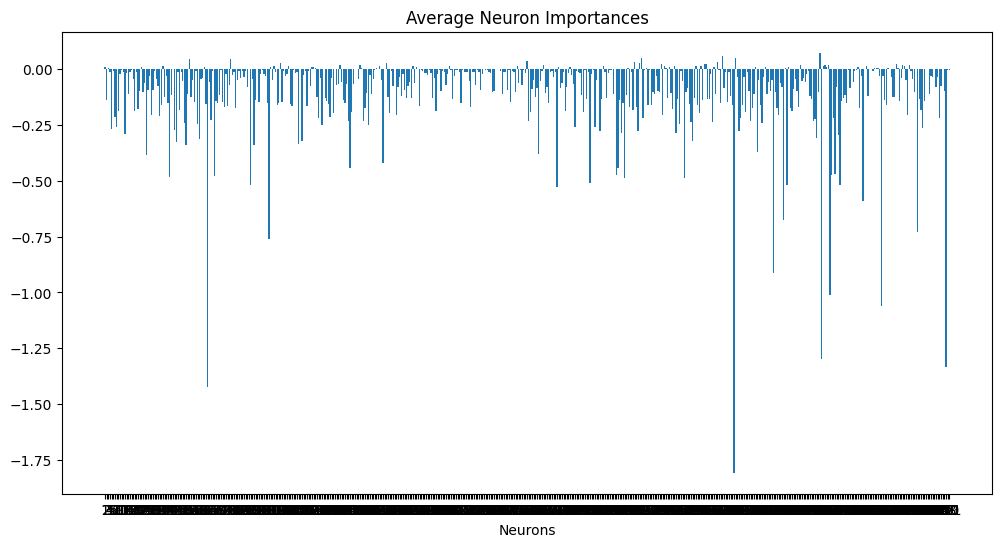

In [324]:
lbound = 1
rbound = 512
cond_vals = cond_vals_per_layer[0]
visualize_importances(range(lbound, rbound),np.mean(cond_vals[:,lbound:rbound], axis=0),title="Average Neuron Importances", axis_title="Neurons")

Average Neuron Importances


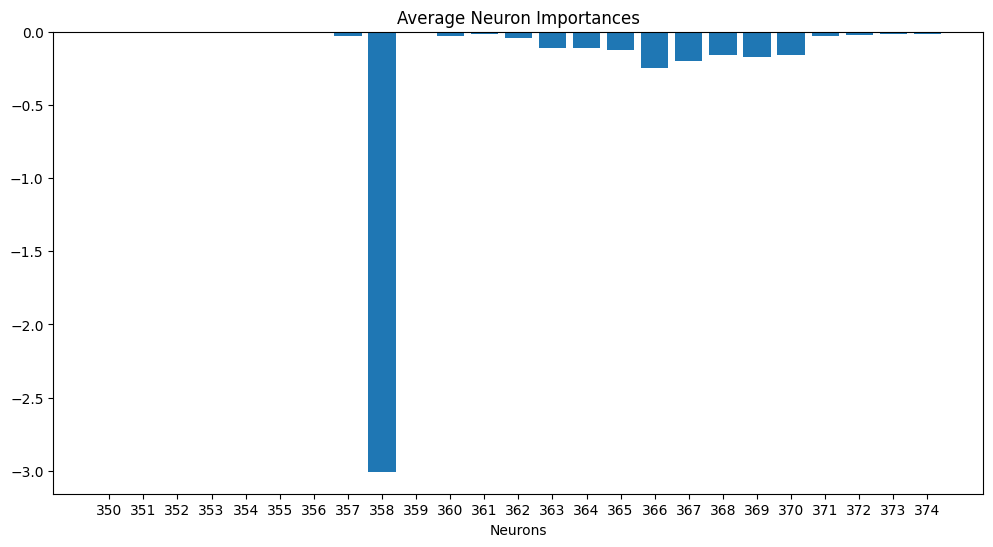

In [328]:
lbound = 350
rbound = 375
cond_vals = cond_vals_per_layer[1]
visualize_importances(range(lbound, rbound),np.mean(cond_vals[:,lbound:rbound], axis=0),title="Average Neuron Importances", axis_title="Neurons")

<Figure size 640x480 with 0 Axes>

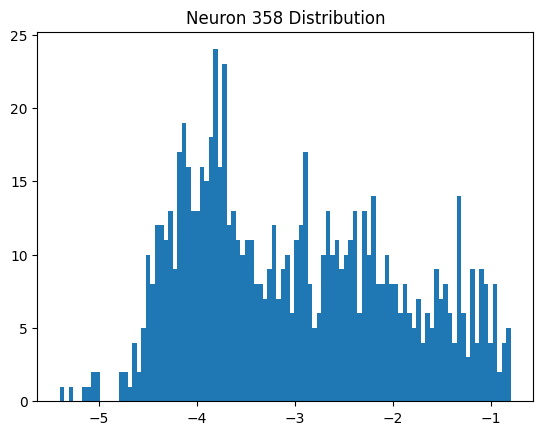

<Figure size 640x480 with 0 Axes>

In [329]:
neuron_i = 358
plt.hist(cond_vals[:,neuron_i], 100)
plt.title(f"Neuron {neuron_i} Distribution")
plt.figure()

Average Feature Importances for Neuron 358


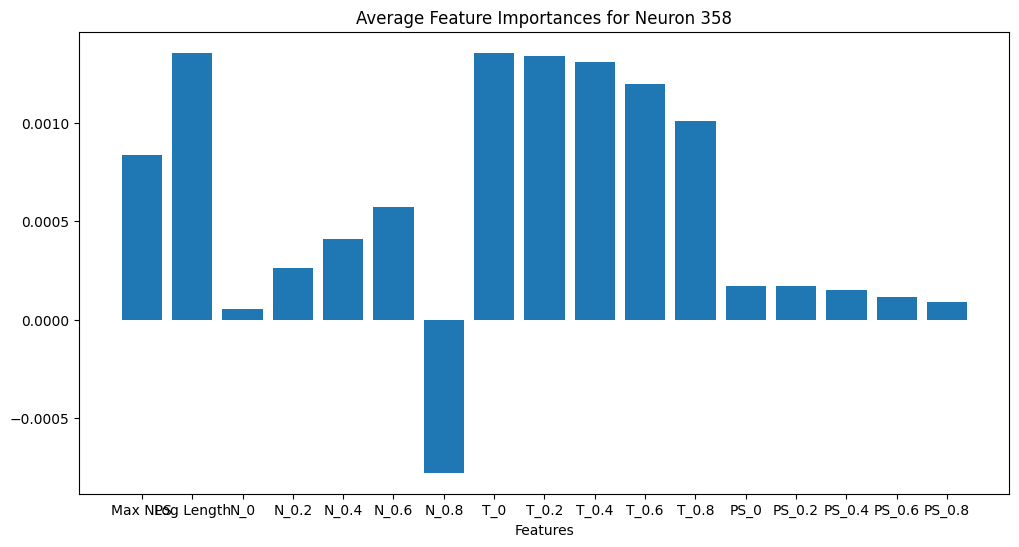

In [330]:
from captum.attr import NeuronConductance
layer_i = 1
neuron_i = 358
neuron_cond = NeuronConductance(classifier.model, layers[0])
neuron_cond_vals = neuron_cond.attribute(test_input, neuron_selector=neuron_i)
visualize_importances(limited_data_columns, neuron_cond_vals.mean(dim=0).detach().cpu().numpy(), title=f"Average Feature Importances for Neuron {neuron_i}")